In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from matplotlib import rcParams

# Some preambles for prettification
rcParams.update({'figure.figsize': (8, 6), 'axes.spines.top': False,
                 'axes.spines.right': False, 'axes.labelsize': 14,
                 'axes.titlesize': 16, 'axes.titleweight': 'bold',
                 'lines.linewidth': 3})

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-3c3d3fdu because the default path (/home/jgacal/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


<a href="https://drive.google.com/file/d/1Q1k4U7_MQzkL8wdmFohTwF4fm5SHsagI/view?usp=sharing"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="float: left;"></a>

# Seatwork 2: Forecasting Electricity Demand w/ Neural Networks

In this seatwork, you will train a neural network model to forecast the hourly electricity demand of the entire Metro Manila (in megawatts). Specifically, your goal is to build a **1-hour ahead forecaster**.

We will be using the `elecmm_20172019` dataset which covers the period of January 1, 2017 to December 31, 2019.

## Data Loading

We first load the dataset using pandas and convert the indices into `pandas.DatetimeIndex` objects.

Then we can plot the time series and calculate some summary statistics.

In [2]:
df = pd.read_csv('elecmm_20172019.csv', index_col=0)
df.index = pd.to_datetime(df.index)

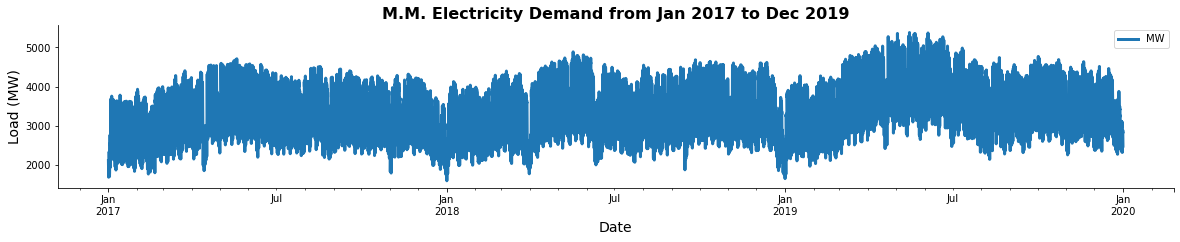

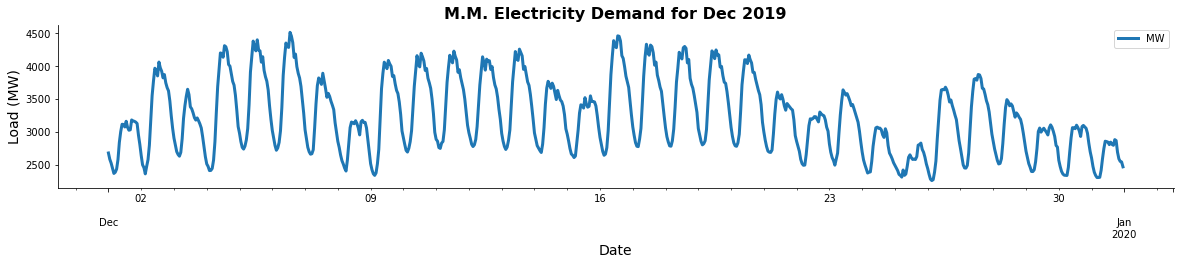

,MW
count,26280.00
mean,3336.68
std,674.70
min,1586.90
25%,2794.10
50%,3316.10
75%,3854.22
max,5381.80


In [3]:
# Plot full series
df.plot(figsize=(20, 3))
plt.title('M.M. Electricity Demand from Jan 2017 to Dec 2019')
plt.xlabel('Date')
plt.ylabel('Load (MW)')
plt.autoscale()
plt.show()

# Plot last month of series
df.loc['2019-12'].plot(figsize=(20, 3))
plt.title('M.M. Electricity Demand for Dec 2019')
plt.xlabel('Date')
plt.ylabel('Load (MW)')
plt.autoscale()
plt.show()

# Summary stats
df.describe().round(2)

## Train-Val-Test Split and Scaling

Let's use the following dates as our train-val-test split:

- Train Set: `2017-01-01` to `2018-11-30`

- Val Set: `2018-12-01` to `2019-11-30` (12 months)

- Test Set: `2019-12-01` to `2019-12-31` (1 month)

In [4]:
# Train-Val-Test
train_idx = df.loc[:'2018-11-30'].index
val_idx = df.loc['2018-12-01':'2019-11-30'].index
test_idx = df.loc['2019-12-01':].index

print(f'Train size: {len(train_idx)}')
print(f'  Val size: {len(val_idx)}')
print(f' Test size: {len(test_idx)}')

Train size: 16776
  Val size: 8760
 Test size: 744


We can then standardize the dataset.

In [5]:
# Standard scale
train_mean = df.loc[train_idx].mean()
train_std = df.loc[train_idx].std()

df_scaled = (df - train_mean) / train_std

## Data Windowing

We will now window our dataset and create batching iterators.

For this problem, we will set the lookback window $w = 24$ and horizon $h = 1$.

In addition, we will use the following settings for the test dataset:

- `batch_size=9999` to use the full batch rather than a minibatch.

- `shuffle=False` to preserve the order of observations.

<div class="alert alert-info">
    
**Important Note on Hold-out Splitting and Windowing:**

In this implementation, we will be throwing away the first $w=24$ observations in each dataset (train, val, and test). In general, you can use the full allocation for the validation and test sets by also appending the previous $w$ observations *before* passing it to the `timeseries_dataset_from_array` functions.
    
</div>

In [6]:
# Hyperparams
w = 24
h = 1

# Split the dataset
ts_train = df_scaled.loc[train_idx].to_numpy()
ts_val = df_scaled.loc[val_idx].to_numpy()
ts_test = df_scaled.loc[test_idx].to_numpy()

# Other params
batch_size = 32
seed = 1337
shuffle = True

# Create train iterators
x_train = tf.keras.utils.timeseries_dataset_from_array(
    data=ts_train[:-h, :],
    targets=None,
    sequence_length=w,
    batch_size=batch_size,
    shuffle=shuffle,
    seed=seed
)

y_train = tf.keras.utils.timeseries_dataset_from_array(
    data=ts_train[w:, 0],
    targets=None,
    sequence_length=h,
    batch_size=batch_size,
    shuffle=shuffle,
    seed=seed
)

# Create val iterators
x_val = tf.keras.utils.timeseries_dataset_from_array(
    data=ts_val[:-h, :],
    targets=None,
    sequence_length=w,
    batch_size=batch_size,
    shuffle=shuffle,
    seed=seed
)

y_val = tf.keras.utils.timeseries_dataset_from_array(
    data=ts_val[w:, 0],
    targets=None,
    sequence_length=h,
    batch_size=batch_size,
    shuffle=shuffle,
    seed=seed
)

# Create test iterators
x_test = tf.keras.utils.timeseries_dataset_from_array(
    data=ts_test[:-h, :],
    targets=None,
    sequence_length=w,
    batch_size=9999,
    shuffle=False,
    seed=seed
)

y_test = tf.keras.utils.timeseries_dataset_from_array(
    data=ts_test[w:, 0],
    targets=None,
    sequence_length=h,
    batch_size=9999,
    shuffle=False,
    seed=seed
)

# zip datasets
train_ds = tf.data.Dataset.zip((x_train, y_train))
val_ds = tf.data.Dataset.zip((x_val, y_val))
test_ds = tf.data.Dataset.zip((x_test, y_test))

# Check sizes
x, y = next(iter(train_ds))
print('Train batch shape')
print(x.shape)
print(y.shape)

x, y = next(iter(val_ds))
print('Val batch shape')
print(x.shape)
print(y.shape)

x, y = next(iter(test_ds))
print('Test batch shape')
print(x.shape)
print(y.shape)


2022-02-07 16:22:03.812744: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-07 16:22:04.636493: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10419 MB memory:  -> device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:60:00.0, compute capability: 6.1
2022-02-07 16:22:05.228711: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Train batch shape
(32, 24, 1)
(32, 1)
Val batch shape
(32, 24, 1)
(32, 1)
Test batch shape
(720, 24, 1)
(720, 1)


## Baseline Model - Multilayer Perceptron

### Task 1 Model Building [2 pts]

Let's use a multilayer perceptron (MLP) as our baseline model.

Create a baseline neural network using keras' **Sequential API** with the following layers:

1. A `Flatten` layer that takes in an input shape of `(24, 1)`.
2. A `Dense` layer with 32 units and `relu` activation function.
3. A `Dense` layer with 1 units and `linear` activation function (i.e. no activation).

The model.summary() should look as follows:

```
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
flatten (Flatten)            (None, 24)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                800       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
=================================================================
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________
```

Complete the model definition below by calling the correct layers and parameters as prescribed by the above architecture.

In [7]:
# Fill in the layers inside the sequential model to create the prescribed architecture

model_mlp = tf.keras.Sequential([
    # Flatten Layer,
    tf.keras.layers.Flatten(input_shape=(24,1)),
    tf.keras.layers.Dense(32, activation='relu'),
    # Dense layer,
    tf.keras.layers.Dense(1)
    # Dense Layer,
])



In [8]:
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 24)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                800       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________


In [9]:
assert len(model_mlp.layers) > 0, "Complete the model definition above"

### Task 2 Model Compilation [1 pts]

Compile the model using the following optimizer, metric, and loss function:

1. Optimizer - `Adam`
2. Loss - `huber`
3. Metrics - `mae`

Perform the model compilation step with the correct parameters by completing the code below:

In [10]:
model_mlp.compile(
    # Optimizer,
    optimizer='Adam',
    loss = 'huber',
    metrics=['mae']
    # Loss,
    # Metrics
)



In [11]:
assert len(model_mlp.loss) > 0, "Perform the model compilation step"

### Task 3 Model Fitting [1 pts]

Fit the MLP on `train_ds` and save the returned `History` object inside `history` variable. 

Set the number of epochs to `5` and use `val_ds` as the validation set.

In [12]:
# Perform the model fitting step here

history = model_mlp.fit(train_ds, epochs=5, validation_data=val_ds)


Epoch 1/5
524/524 [==============================] - 8s 14ms/step - loss: 0.0535 - mae: 0.2117 - val_loss: 0.0226 - val_mae: 0.1573
Epoch 2/5
524/524 [==============================] - 7s 14ms/step - loss: 0.0101 - mae: 0.1077 - val_loss: 0.0132 - val_mae: 0.1209
Epoch 3/5
524/524 [==============================] - 7s 14ms/step - loss: 0.0069 - mae: 0.0894 - val_loss: 0.0106 - val_mae: 0.1074
Epoch 4/5
524/524 [==============================] - 7s 14ms/step - loss: 0.0058 - mae: 0.0819 - val_loss: 0.0098 - val_mae: 0.1037
Epoch 5/5
524/524 [==============================] - 7s 14ms/step - loss: 0.0051 - mae: 0.0775 - val_loss: 0.0081 - val_mae: 0.0937


In [13]:
assert history is not None, "Perform the model fitting step then save the result on the history variable"

(<Figure size 1152x360 with 2 Axes>,
 array([<AxesSubplot:xlabel='Epochs', ylabel='MAE'>,
        <AxesSubplot:xlabel='Epochs', ylabel='Loss'>], dtype=object))

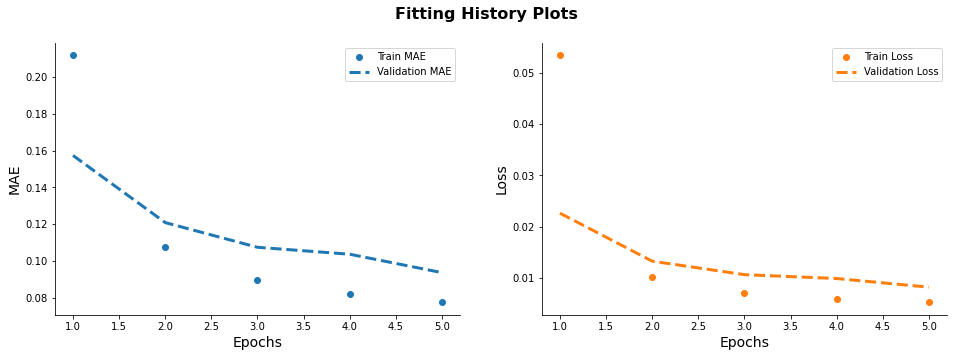

In [14]:
def plot_history(history):
    """Adapted from SW1.
    """
    # Get metrics and losses from history object
    mae = history.history['mae']
    loss = history.history['loss']
    val_mae = history.history['val_mae']
    val_loss = history.history['val_loss']
    
    # Generate epoch number list
    epochs = range(1, len(mae) + 1)

    # Initialize figure
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # Plot epochs and metrics/loss values
    axes[0].plot(epochs, mae, 'o', color='tab:blue',
                 label='Train MAE')
    axes[0].plot(epochs, val_mae, '--', color='tab:blue',
                 label='Validation MAE')
    axes[1].plot(epochs, loss, 'o', color='tab:orange', label='Train Loss')
    axes[1].plot(epochs, val_loss, '--', color='tab:orange',
                 label='Validation Loss')

    # Add axis labels and legends
    for ax in axes:
        ax.set_xlabel("Epochs")
        ax.legend()
    axes[0].set_ylabel("MAE")
    axes[1].set_ylabel("Loss")
    fig.suptitle("Fitting History Plots", fontsize=16, weight='bold')

    return fig, axes

plot_history(history)

### Task 4 Model Evaluation [1 pts]

Let's calculate how well the MLP model performs on the test dataset `test_ds`.

Compute the test loss and test MAE of the model. Save the results on the test_loss and test_mae variable respectively.

In [15]:
test_loss, test_mae = model_mlp.evaluate(test_ds)



print(f"Test Loss: {test_loss:.4f}")
print(f" Test MAE: {test_mae:.4f}")

1/1 [==============================] - 0s 164ms/step - loss: 0.0054 - mae: 0.0793
Test Loss: 0.0054
 Test MAE: 0.0793


In [16]:
assert test_loss is not None
assert test_mae is not None

## LSTM Encoder-Decoder Model

### Task 5 Model Building [2 pts]

Let's see if we can improve our performance by using a LSTM Encoder-Decoder architcture.

Implement the following architecture by subclassing `tf.keras.Model`:

![LSTM Seq2Seq](architecture.PNG)

For this implementation, we'll set the number of hidden units to `32`.

In [17]:
class seq2seq_lstm(tf.keras.Model):
    def __init__(self, window, horizon, hidden_units):
        super(seq2seq_lstm, self).__init__()
        
        # Parameters
        self.window = window
        self.horizon = horizon
        self.hidden_units = hidden_units
        
        # LSTM encoder
        self.encoder = tf.keras.layers.LSTM(self.hidden_units, 
                                            return_sequences=False, 
                                            return_state=True)
        
        # LSTM decoder
        self.decoder = tf.keras.layers.LSTM(self.hidden_units, 
                                            return_sequences=False, 
                                            return_state=True)
        
        # Output layer
        self.dense = tf.keras.layers.Dense(1)

    def call(self, x, state=None):
        output = []
        
        # Forward prop
        encoder_output, encoder_state_h, encoder_state_c = self.encoder(x, initial_state=state)
        
        encoder_output = tf.expand_dims(encoder_output, 1) # reshape to (batch, time, features)
        decoder_input = self.dense(encoder_output)
        
        
        decoder_output, decoder_state_h, decoder_state_c = self.decoder(decoder_input, initial_state=[encoder_state_h, encoder_state_c])
        decoder_input = self.dense(decoder_output)
        
        output.append(decoder_input)
        
        for i in range(1, self.horizon):
            
            decoder_input = tf.expand_dims(decoder_input, 1) # reshape to (batch, time, features)

            decoder_output, decoder_state_h, decoder_state_c = self.decoder(decoder_input, initial_state=[decoder_state_h, decoder_state_c])
            decoder_input = self.dense(decoder_output)
            
            output.append(decoder_input)
        
        output = tf.stack(output)                # (time, batch, features)
        output = tf.transpose(output, [1, 0, 2])
        
        return output
    
hidden_units = 32

model = seq2seq_lstm(w, h, hidden_units)
    


In [18]:
assert len(model.layers) > 0, "Complete the model definition above"

### Task 6 Model Compilation [1 pts]

Similar to the MLP model, compile the seq2seq model using the following optimizer, metric, and loss function:

1. Optimizer - `Adam`
2. Loss - `huber`
3. Metrics - `mae`

Perform the model compilation step with the correct parameters by completing the code below:

In [19]:
model.compile(
    # Optimizer,
    optimizer='Adam',
    loss='huber',
    metrics=['mae']
    # Loss,
    # Metrics
)



In [20]:
assert len(model.loss) > 0, "Perform the model compilation step"

### Task 7 Model Fitting [1 pts]

Fit the seq2seq model on `train_ds` and save the returned `History` object inside `history` variable. 

Set the number of epochs to `5` and use `val_ds` as the validation set.

In [21]:
# history = None # Perform the model fitting step here
history= model.fit(train_ds, epochs=5, validation_data=val_ds)


Epoch 1/5


2022-02-07 16:22:47.158538: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101


524/524 [==============================] - 14s 20ms/step - loss: 0.0372 - mae: 0.1828 - val_loss: 0.0197 - val_mae: 0.1447
Epoch 2/5
524/524 [==============================] - 10s 19ms/step - loss: 0.0091 - mae: 0.1045 - val_loss: 0.0181 - val_mae: 0.1346
Epoch 3/5
524/524 [==============================] - 10s 19ms/step - loss: 0.0071 - mae: 0.0917 - val_loss: 0.0140 - val_mae: 0.1161
Epoch 4/5
524/524 [==============================] - 10s 19ms/step - loss: 0.0058 - mae: 0.0824 - val_loss: 0.0119 - val_mae: 0.1067
Epoch 5/5
524/524 [==============================] - 10s 18ms/step - loss: 0.0051 - mae: 0.0771 - val_loss: 0.0107 - val_mae: 0.1001


In [22]:
assert history is not None, "Perform the model fitting step then save the result on the history variable"

(<Figure size 1152x360 with 2 Axes>,
 array([<AxesSubplot:xlabel='Epochs', ylabel='MAE'>,
        <AxesSubplot:xlabel='Epochs', ylabel='Loss'>], dtype=object))

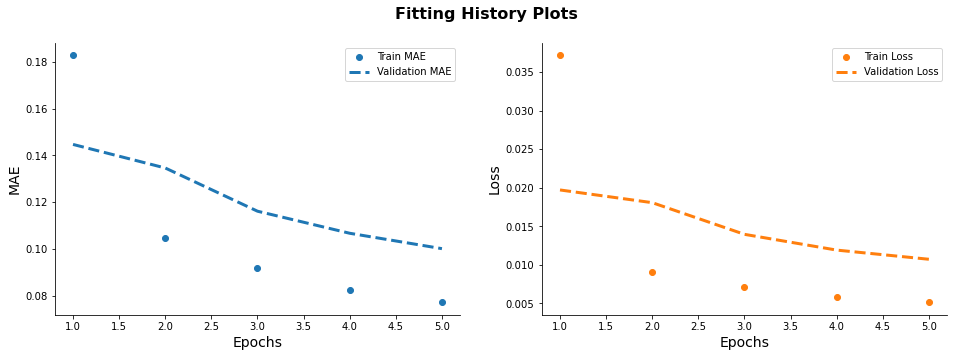

In [23]:
plot_history(history)

### Task 8 Model Evaluation [1 pts]

Let's calculate how well the seq2seq model performs on the test dataset `test_ds`.

Compute the test loss and test MAE of the model. Save the results on the test_loss and test_mae variable respectively.

In [24]:
test_loss, test_mae = model.evaluate(test_ds)



print(f"Test Loss: {test_loss:.4f}")
print(f" Test MAE: {test_mae:.4f}")

1/1 [==============================] - 0s 148ms/step - loss: 0.0054 - mae: 0.0769
Test Loss: 0.0054
 Test MAE: 0.0769


In [25]:
assert test_loss is not None
assert test_mae is not None

### Task 9 MLP vs LSTM Encoder-Decoder [2 pts]

Comment on the performance of the LSTM Encoder-Decoder model and compare it with our baseline MLP model.

What are some possible reasons why the results turned out this way?

PLACE YOUR ANSWER HERE

> the baseline model (MLP) and the custom architecture (LSTM Encoder-Decoder) performed equally in trying to do a 1-hour ahead forecast. Since the task is just to predict 1 hour, both models will perform relatively equal with each other. However, if the task was to predict several hours ahead, then theoretically, LSTM should perform better since it better captures the context of a sequence of inputs during training, while MLP does not. In terms of runtime, MLP took less time to train than LSTM. This may be because LSTM has a lot more operations/equations than MLP.